In [2]:
# Global imports and style settings
using PyPlot, Distributions, LaTeXStrings, PyCall
plt.style[:use]("mystyle.mplstyle");

INFO: Loading help data...


# Monte Carlo Methods

## Generating Random Variables

This section answers the question "How can we draw samples of univariate random variable $X$ with cumulative distribution function (CDF) $F(x)$?".

Throughout, we will assume that we have some efficient algorithm to generate uniform random variables, $U\sim \text{Unif}([0,1])$, and then build to more complex distributions from this starting point.

### Inverse Transform Method

#### Intuition

Suppose we want to draw samples of some arbitrary random variable $X$ with CDF denoted $F(x)$. (A specific example of a $\text{Beta}(\alpha,\beta)$ RV is plotted below, though the intuition will hold for any Random Variable.) 

Now by the definition of the CDF, for any draw $\hat{x}$, the value $F(\hat{x})$ must lie on [0,1].

This suggests the following approach for sampling draws of $X$:
* Throw independent $\text{Unif}[0,1]$ RV's, denoted $\hat{u}_i$, agfainst the $y$-axis
* Map those draws to the corresponding unique $\hat{x}_i$ draws on the $x$-axis.

The arrows show specific examples and the order to proceed in.

When the CDF is steep, a small change in a $\hat{u}_i$ draw won't change the corresponding $\hat{x}_i$ very much; therefore, we'll accumulate lots of mass clustered around such $\hat{x}_i$ over many draws. The opposite holds when the CDF is flat. In this way, we map uniform draws (which are easy to draw from using fast algorithms) directly into draws that match other highly non-uniform distributions. 

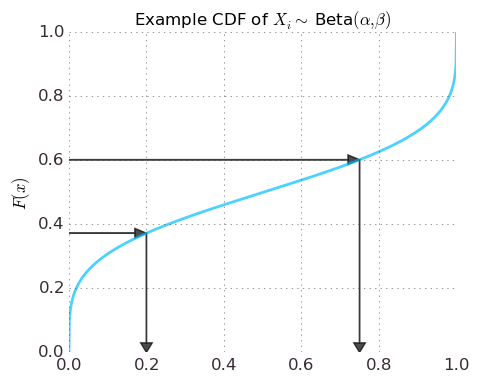

In [3]:
α, β = 0.25, 0.25
f, F = map((fcn) -> ((x) -> fcn(Beta(α,β), x)), [pdf, cdf])
x = 0:0.001:1

p = Array(Any,4)
figure(figsize=(5,4))

plot(x,F(x), alpha=0.7);
lines_at = [0.2, 0.75]; arwsz = 0.03;
draw_arrow = (x,y,dx,dy,sz) -> arrow(x, y, dx, dy, head_width=sz,head_length=sz)
p[1:2] = map(x -> draw_arrow(0, F(x), x-arwsz, 0, arwsz), lines_at)
p[3:4] = map(x -> draw_arrow(x, F(x), 0, -F(x)+arwsz, arwsz), lines_at)
map(ph -> setp(ph, facecolor="black", edgecolor="black", alpha=0.7), p)
ylabel(L"$F(x)$"); title(L"Example CDF of $X_i \sim $ Beta$(\alpha,\beta)$");

#### The Math


To see why this works, suppose $X$ is some random variable with invertible CDF $F(x)$. Next suppose that $U\sim\text{Unif}([0,1])$.

If we set $X' = F^{-1}(U)$, then $X'$ will have the same distribution as $X$.

_Proof_
$$
\begin{align*}
    \text{CDF of $X'$} = P(X' < x) &= P(F^{-1}(U) < x) \\
    &= P(U < F(x)) = F(x) = \text{CDF of $X$}
\end{align*}
$$

When $X$ is discrete, this procedure can be modified by drawing $U$ as before and setting $X' = \inf \{x : F(x) > u\}$.

#### Numerical Example

Suppose we want to draw $X_i \sim \text{Exp}(\lambda)$. This has pdf and cdf as follows:

$$
\begin{align*}
    f(x) = \lambda e^{-\lambda x} \qquad F(x) &= 1 - e^{-\lambda x} \\
    \Rightarrow \quad F^{-1}(u) &= -\frac{1}{\lambda}\ln(1-u)
\end{align*}
$$

The three panels below show the different steps:
1. Simulate $N$ draws from a uniform. The histogram depicts one particular example.
2. For $i=1,\ldots,N$, set $\hat{x}_i = F^{-1}(\hat{u}_i)$. The resulting empirical CDF for the $\hat{x}_i$ draws is plotted against the true analytical CDF for comparison. 
3. Plot the analytical pdf against the samples of $\hat{x}_i$ generated by the inverse transform method. 

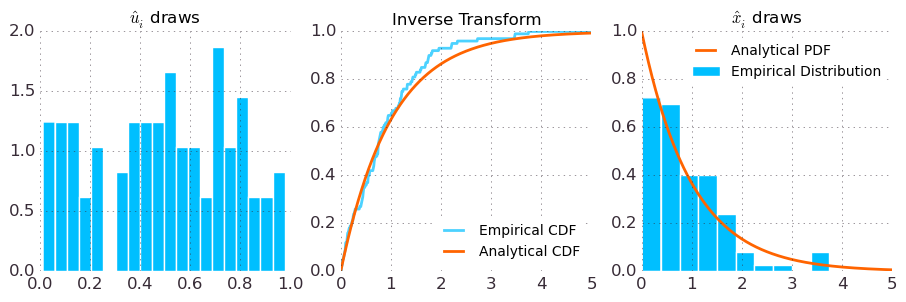

In [4]:
N = 100
λ = 1
f, F = map((fcn) -> ((x) -> fcn(Exponential(λ), x)), [pdf, cdf])
Finv = (u) -> -(1/λ)*log(1 - u)

u_draws = rand(N)
x_draws = Finv(u_draws)
support, counts = hist(x_draws, 0:0.01:5)

figure(figsize=(11,3))
subplot(131)
plt.hist(u_draws, 20, normed=1), title(L"$\hat{u}_i$ draws")

subplot(132)
plot(support[2:end], cumsum(counts)/N, alpha=0.7)
plot(support, F(support))
title("Inverse Transform"); legend(("Empirical CDF","Analytical CDF"), loc="lower right")

subplot(133)
plt.hist(x_draws, normed=1)
plot(support, f(support))
legend(("Analytical PDF", "Empirical Distribution")); title(L"$\hat{x}_i$ draws");

#### Drawbacks and Limitations

There's really only one: You need to be able to invert the CDF to get $F^{-1}(u)$ analytically. 

So in practice, this method only works for uniform (duh), exponential, Cauchy, Weibull, logistic, and discrete RVs. For more general distributions, we'll have to use other methods.

### Acceptance-Rejection Method

#### Intuition

Acceptance-Rejection builds directly upon the Inverse Transform Method, but allows random sampling of *any* arbitrary univariate RV--not just those with invertible CDFs.

To get the intuition, suppose that we want to draw samples of target random variable $X$ with pdf $f(x)$, but we cannot use the inverse transform method. Next suppose that we *can* draw random samples of some pseudo-random variable $X'$ with proposal distribution $g(x)$ that covers $f(x)$. ("Pseudo" because the density will not integrate to one, and we'll have to normalize at some point in the process. More on that later.)

An example is plotted below of the target pdf $f(x)$ for $X\sim N(0,1)$ and a covering proposal distribution $g(x)$ for $X'$. We then apply the following procedure:
1. Draw $\hat{x}'$ from the proposal distribution, $g(x)$.
2. Accept $\hat{x}'$ as a draw for $X$ with probability equal to $\frac{f(x')}{g(x')}$.

Said another way, we draw to match proposal distribution $g(x)$ because it's easy and tractable. But since that isn't quite the distribution we want, we'll randomly reject a fraction of draws so that we match our target $f(x)$ in the limit. When the proposal distribution $g(x)$ is very different from $f(x)$--i.e. $g(x)~>>~f(x)$--there will be a larger "correction" that manifests in a higher rejection rate. 

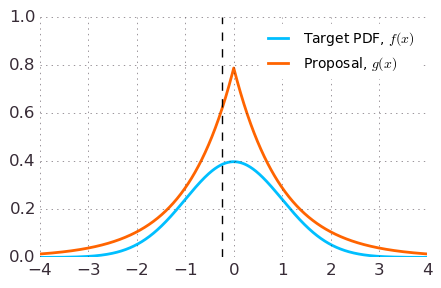

In [5]:
f = (x) -> pdf(Normal(0,1), x)
α = 1.2sqrt(e/(2*π))
g = (x) -> α*exp(-abs(x))
x = -4:0.01:4

figure(figsize=(5,3))
map((fcn) -> plot(x, fcn(x)), [f, g])
plot(-0.25*ones(2,1), [0, 1], color="black", linestyle="--", linewidth=1)
legend((L"Target PDF, $f(x)$", L"Proposal, $g(x)$"),fontsize=10);

#### The Math

We want to generate samples of some random variable $X$ with PDF $f(x)$. 

To do so, we first find a covering proposal distribution $g(x)$ such that

$$
    \forall x \quad g(x) > f(x) 
    \qquad \text{and} \qquad
    G(x) = \int^x_{-\infty} g(x) \; dx
$$

where $G(x)$ is such that
* $G^{-1}(u)$ exists
* $\lim_{x\rightarrow\infty} G(x) = k < \infty$

Then we can generate draws of $X$ using the following algorithm:
1. Draw $\hat{u}$ from a $\text{Unif}([0,1])$ distribution.
2. Set $\hat{x}' = G^{-1}(k\cdot\hat{u})$ where $k$ is the normalizing constant (defined above) so that $\lim_{x\rightarrow\infty}\frac{1}{k}G(x) =1$.
3. Draw $\hat{r}$ from a $U([0,1])$ distribution.
4. Accept draw and set $x = \hat{x}'$ if 
$$
    0 \leq \hat{r} \leq \frac{f(x)}{g(x)}
$$
Reject otherwise.
5. Repeat until you have accepted $N$ draws.

Code to implement this scheme below.

In [6]:
function AcceptReject(N, f, Ginv, k)
    n = 0
    proposed = Array(Float64,0)
    xdraws   = Array(Float64,N)
    while n < N
        u,r = rand(2)
        xp  = Ginv(k*u)
        if r ≤ f(xp)/g(xp)
            n += 1
            xdraws[n] = xp
        end
        push!(proposed,xp)
    end
    return xdraws, proposed
end;

**Final Note:** Ideally, we choose $g(x)$ so that it matches $f(x)$ as closely as possible and minimizes

$$
    \int^\infty_{-\infty} [g(x)-f(x)] dx
$$

subject to the constraint that still $g(x)>f(x)$ for all $x$ and $G(x)$ is invertible. 

This minimizes "wasted area" between $f(x)$ and $g(x)$ that corresponds to higher a higher rejection rate and wasted draws.

#### Numerical Example

We'll use the example from the intuition section above where $X\sim N(0,1)$ and the target PDF and proposal distribution are, respectively,

$$
    f(x) = \frac{1}{\sqrt{2\pi}} e^{-\frac{x^2}{2}}
    \qquad
    g(x) = \sqrt{\frac{e}{2\pi}} e^{-|x|}
$$


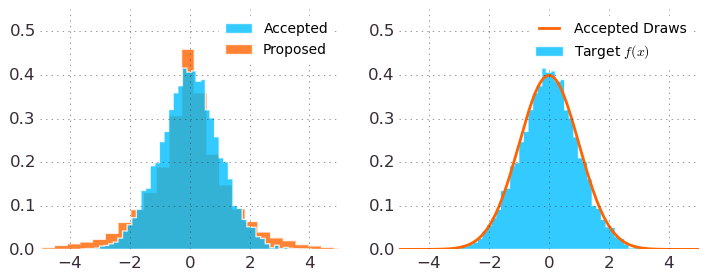

In [7]:
# Define target and proposal distributions
f     = (x) -> pdf(Normal(0,1), x)
α     = sqrt(2e/π)
g     = (x) -> (α/2)*exp(-abs(x))
G     = (x) -> (α/2)*( exp(-abs(x))*(x ≤ 0) + 2*(x>0))
Ginv  = (u) -> (u ≤ α/2)*(log(2u/α)) + (u > α/2)*(-log(2-2u/α))
k     = α #Normalizing constant

# Generate N draws via accept reject
xdraws, proposed = AcceptReject(10000, f, Ginv, k)

# Plot sample
figure(figsize=(8.5,3));
ax = Array(Any, 2)
xl = -5:0.01:5; yl = 0:0.01:0.55;

ax[1] = subplot(121)
map(arg -> plt.hist(arg[1], 50, normed=1, alpha=0.8, histtype="stepfilled", zorder=arg[2]), 
    [(xdraws, 2), (proposed, 1)])
legend(("Accepted", "Proposed"));

ax[2] = subplot(122)
plt.hist(xdraws, 50, normed=1, alpha=0.8, histtype="stepfilled")
plot(xl, f(xl))
legend(("Accepted Draws", L"Target $f(x)$"))

map(x -> setp(x, xlim=(xl[1],xl[end]), ylim=(yl[1], yl[end])), ax);